In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


In [2]:
# What waveforms can I generate?
from pycbc.waveform import td_approximants, fd_approximants

# list td approximants available
print (td_approximants())

print (fd_approximants())

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


['IMRPhenomD_NRTidal', 'TaylorF2', 'TaylorEt', 'SEOBNRv3_opt', 'IMRPhenomA', 'IMRPhenomC', 'IMRPhenomB', 'EOBNRv2', 'NRSur7dq2', 'SEOBNRv2_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SpinTaylorF2', 'IMRPhenomPv2_NRTidal', 'SpinTaylorF2_SWAPPER', 'IMRPhenomHM', 'SEOBNRv2_ROM_DoubleSpin_HI', 'EOBNRv2_ROM', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv4_opt', 'TaylorF2NL', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'NR_hdf5', 'TEOBResum_ROM', 'SEOBNRv4_ROM', 'SEOBNRv3_pert', 'EOBNRv2HM', 'SpinTaylorT4', 'TaylorT1', 'EOBNRv2HM_ROM', 'TaylorT3', 'TaylorT2', 'HGimri', 'TaylorT4', 'IMRPhenomD', 'IMRPhenomPv2', 'SEOBNRv4T', 'SEOBNRv2T', 'SEOBNRv1', 'SpinDominatedWf', 'SEOBNRv3', 'SEOBNRv2', 'SpinTaylorT1', 'SEOBNRv4', 'SpinTaylorT2', 'SEOBNRv4HM', 'EccentricTD', 'SEOBNRv2_opt', 'SEOBNRv3_opt_rk4']
['IMRPhenomD_NRTidal', 'TaylorF2', 'TaylorF2Ecc', 'SEOBNRv2_ROM_EffectiveSpin', 'IMRPhenomA', 'IMRPhenomC', 'SEOBNRv1_ROM_EffectiveSpin', 'IMRPhenomD', 'SpinTaylorT2Fourier', 'IMRP

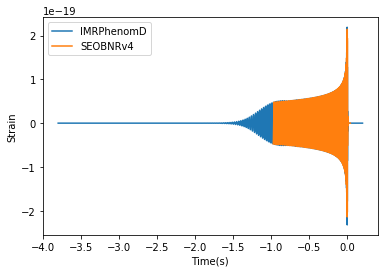

In [9]:
# Plotting time domain waveforms
%matplotlib inline
import pylab
from pycbc.waveform import get_td_waveform

for apx in ['IMRPhenomD','SEOBNRv4']:
    hp,hc = get_td_waveform(approximant=apx,mass1=10,mass2=10,spin1z=0.9,delta_t=1.0/4096,f_lower=40)
    pylab.plot(hp.sample_times,hp,label=apx)

pylab.ylabel('Strain')
pylab.xlabel('Time(s)')
pylab.legend()
pylab.show()


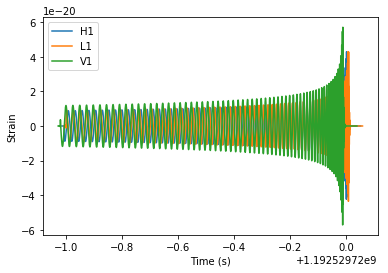

In [10]:
# Generating one waveform in multiple detectors
import pylab
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

apx = 'SEOBNRv4'
hp,hc = get_td_waveform(approximant=apx,mass1=10,mass2=10,spin1z=0.9,spin2z=0.4,inclination=1.23,coa_phase=2.45,delta_t=1.0/4096,f_lower=40)
# inclination runs from 0 to pi, coa_phase runs from 0 to 2pi

det_h1 = Detector('H1')
det_l1 = Detector('L1')
det_v1 = Detector('V1')

# RA and polarization phase runs from 0 to 2pi, Dec runs from pi/2. to -pi/2.

end_time=1192529720
declination=0.65
right_ascension=4.67
polarization=2.34

hp.start_time +=end_time
hc.start_time +=end_time

signal_h1 = det_h1.project_wave(hp,hc, right_ascension,declination,polarization)
signal_l1 = det_l1.project_wave(hp,hc, right_ascension,declination,polarization)
signal_v1 = det_v1.project_wave(hp,hc, right_ascension,declination,polarization)

pylab.plot(signal_h1.sample_times,signal_h1,label='H1')
pylab.plot(signal_l1.sample_times,signal_l1,label='L1')
pylab.plot(signal_v1.sample_times,signal_v1,label='V1')

pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()


In [13]:
# Calculating the match between waveforms
from pycbc.waveform import get_td_waveform
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower

f_low=30
sample_rate=4096

# Generate 2 waveforms to compare
hp,hc = get_td_waveform(approximant="IMRPhenomD",
                       mass1=10,
                       mass2=10,
                       f_lower=f_low,
                       delta_t=1.0/sample_rate)

sp,sc = get_td_waveform(approximant="SEOBNRv4",
                       mass1=10,
                       mass2=10,
                       f_lower=f_low,
                       delta_t=1.0/sample_rate)

# Resize the waveforms to the same length
tlen = max(len(sp),len(hp))
sp.resize(tlen)
hp.resize(tlen)

# Generate the aLIGO ZDHP PSD (noise power spectrum)
delta_f = 1.0 / sp.duration
flen = tlen/2 +1
psd = aLIGOZeroDetHighPower(flen,delta_f,f_low)

m,i = match(hp,sp,psd=psd, low_frequency_cutoff=f_low)
o = overlap(hp,sp,psd=psd,low_frequency_cutoff=f_low)

print("Overlap is %s" % o)
print("Match is %s" % m)


Overlap is -0.0005224667458506885
Match is 0.9898396915547032


In [14]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower

f_low=20
sample_rate=4096

matches = []
overlaps = []

# Fix mass1=10
mass1 = 10
masses2 = range(10,31,2)

for mass2 in masses2:
    # Generate 2 waveforms to compare
    hp,hc = get_td_waveform(approximant="IMRPhenomD",
                       mass1=mass1,
                       mass2=mass2,
                       f_lower=f_low,
                       delta_t=1.0/sample_rate)

    sp,sc = get_td_waveform(approximant="SEOBNRv4",
                       mass1=mass1,
                       mass2=mass2,
                       f_lower=f_low,
                       delta_t=1.0/sample_rate)
    tlen = max(len(hp),len(sp))
    hp.resize(tlen)
    sp.resize(tlen)
    
    # Generate psd
    delta_f = 1.0/sp.duration
    flen = tlen/2 +1
    psd = aLIGOZeroDetHighPower(flen,delta_f,f_low)
    
    m,i = match(hp,sp,psd=psd,low_frequency_cutoff=f_low)
    o = overlap(hp,sp,psd=psd,low_frequency_cutoff=f_low)
    
    matches.append(m)
    overlaps.append(o)
    
print ("Overlaps are %s" % overlaps )
print ("Matches are %s" % matches)




Overlaps are [-9.067683280142268e-05, -0.00010741905021617983, -0.00012231354405027234, -0.000136346041354386, -0.00014997609694742, -0.0001634935046848536, -0.00017703567213907668, -0.00019233006212010788, -0.00021114273621635418, -0.0002295544419076357, -0.0002478689720804179]
Matches are [0.9893804831540857, 0.9918320682572949, 0.9908880979725467, 0.9889494703374708, 0.9869993118459759, 0.9888236259964953, 0.9879500868390354, 0.9881192628585649, 0.9873104426199503, 0.9877136186992084, 0.9891562704830901]


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


Matches are [[0.98938048 0.99183207 0.9908881  0.98894947 0.98699931 0.98882363
  0.98795009 0.98811926 0.98731044 0.98771362 0.98915627]
 [0.99183207 0.99023172 0.99081263 0.9910305  0.98813577 0.98993139
  0.98750491 0.98869068 0.98829728 0.98845868 0.98961221]
 [0.9908881  0.99081263 0.99208432 0.9922154  0.99158776 0.9910158
  0.99006836 0.99041408 0.99016121 0.989136   0.98952072]
 [0.98894947 0.9910305  0.9922154  0.99136724 0.9919268  0.99242403
  0.99107984 0.99154421 0.99077726 0.9901754  0.99068354]
 [0.98699931 0.98813577 0.99158776 0.9919268  0.99246996 0.9907132
  0.99236805 0.9907993  0.99176764 0.99030742 0.99048809]
 [0.98882363 0.98993139 0.9910158  0.99242403 0.9907132  0.99282251
  0.99258689 0.99244417 0.99164842 0.99241449 0.99192516]
 [0.98795009 0.98750491 0.99006836 0.99107984 0.99236805 0.99258689
  0.99335026 0.99188216 0.9931857  0.9923677  0.99157751]
 [0.98811926 0.98869068 0.99041408 0.99154421 0.9907993  0.99244417
  0.99188216 0.99314852 0.99286182 0.993

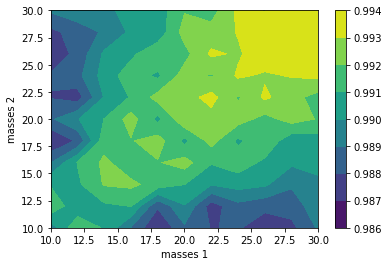

In [1]:
# make it 2d
%matplotlib inline
from pycbc.waveform import get_td_waveform
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower
import pylab
import matplotlib.pyplot as plt
import numpy as np

f_low=20
sample_rate=4096
masses1 = range(10,31,2)
masses2 = range(10,31,2)
matches = np.empty([len(masses1),len(masses2)])
overlaps = np.empty([len(masses1),len(masses2)])

for mass1 in masses1:
    for mass2 in masses2:
        # Generate 2 waveforms to compare
        hp,hc = get_td_waveform(approximant="IMRPhenomD",
                       mass1=mass1,
                       mass2=mass2,
                       f_lower=f_low,
                       delta_t=1.0/sample_rate)

        sp,sc = get_td_waveform(approximant="SEOBNRv4",
                       mass1=mass1,
                       mass2=mass2,
                       f_lower=f_low,
                       delta_t=1.0/sample_rate)
        tlen = max(len(hp),len(sp))
        hp.resize(tlen)
        sp.resize(tlen)
    
        # Generate psd
        delta_f = 1.0/sp.duration
        flen = tlen/2 +1
        psd = aLIGOZeroDetHighPower(flen,delta_f,f_low)
    
        m,i = match(hp,sp,psd=psd,low_frequency_cutoff=f_low)
        o = overlap(hp,sp,psd=psd,low_frequency_cutoff=f_low)
    
        matches[masses1.index(mass1)][masses2.index(mass2)] = m
        overlaps[masses1.index(mass1)][masses2.index(mass2)] = o
    
#print ("Overlaps are %s" % overlaps )
print ("Matches are %s" % matches)

plt.figure()
cp = plt.contourf(masses1,masses2,matches)
plt.colorbar(cp)
plt.xlabel('masses 1')
plt.ylabel('masses 2')
plt.show()




In [26]:
# play around with np.meshgrid
import numpy as np
import matplotlib.pyplot as plt
masses2=masses1= np.linspace(10., 30., num=30)
xv,yv=np.meshgrid(masses1,masses2)
a1=np.linspace(0.,10.,11)
a2=np.linspace(10.,20.,11)
v1,v2=np.meshgrid(a1,a2)
print (a1)
print (a2)
print ("v1 is %s" % v1)
print ("v2 is %s" % v2)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.]
v1 is [[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]]
v2 is [[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.]
 [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]
 [13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.]
 [14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.]
 [15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.]
 [16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.]
 [17. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17.]
 [

In [ ]:
%matplotlib inline
from pycbc.waveform import get_td_waveform
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower
import pylab
import matplotlib.pyplot as plt
import numpy as np

# Function GenTemplate: apx string, mass1 float, mass 2 float, f_low float, sample_rate int; 
# returns a 1D array of two polarized waves from the chosen template.

# Make a 30*30 grid of IMRPhenomD waveforms
def GenTemplate (mass1, mass2, apx="IMRPhenomD", f_low=20, sample_rate=4096):
    polarized_waves = np.empty(2, object)
    hp,hc = get_td_waveform(approximant=apx,
                           mass1=mass1,
                           mass2=mass2,
                           f_lower=f_low,
                           delta_t=1.0/sample_rate)
    polarized_waves[0]=hp
    polarized_waves[1]=hc
    return polarized_waves

masses2=masses1= np.linspace(10., 30., num=30)
#templates_c0=templates_p0=np.empty([len(masses1),len(masses2)], object)
#for i in range(0,len(masses1)):
#    for j in range(0,len(masses2)):
#        templates_p0[i][j]=GenTemplate(masses1[i],masses2[j])[0]
#        templates_c0[i][j]=GenTemplate(masses1[i],masses2[j])[1]

# Do the same for SEOBNRv4
#templates_c1=templates_p1=np.empty([len(masses1),len(masses2)],object)
#for i in range(0,len(masses1)):
#    for j in range(0,len(masses2)):
#        templates_p1[i][j]=GenTemplate(approximant="SEOBNRv4",mass1=masses1[i],mass2=masses2[j])[0]
#        templates_c1[i][j]=GenTemplate(approximant="SEOBNRv4",mass1=masses1[i],mass2=masses2[j])[1]

# Draw one template using SEOBNRv4
#fixed_mass1 = 15
#fixed_mass2 = 20
#p1 = GenTemplate(fixed_mass1,fixed_mass2,apx="SEOBNRv4")[0]
#c1 = GenTemplate(fixed_mass1,fixed_mass2,apx="SEOBNRv4")[1]

# Calculate matches (should get 30*30=900 values)

def GetMatch (template0,template1=p1,f_low=20):
    #resize two templates
    tlen = max(len(template0),len(template1))
    template1.resize(tlen)
    template0.resize(tlen)
    
    #generate psd
    delta_f = 1.0/template1.duration
    flen = tlen/2 +1
    psd = aLIGOZeroDetHighPower(flen,delta_f,f_low)
    
    #calculate match
    m,i = match(template0,template1,psd=psd,low_frequency_cutoff=f_low)
    return m

#matches = np.empty([len(masses1),len(masses2)])
#for i in range(0,len(masses1)):
#    for j in range(0,len(masses2)):
#        matches[i][j]=GetMatch(templates_p0[i][j])

#print (matches)

# Grab the best matched mass1&mass2
#max1 = np.argmax(matches[0])
#print (max1)

max_indices=np.empty(len(masses1))
max_values=np.empty(len(masses1))
for i in range(0,len(masses1)):
    max_indices[i]=np.argmax(matches[i])
    max_values[i]=np.amax(matches[i])


#print (max_indices)
#print (max_values)
#global_max = np.amax(max_values)
#global_max_i = np.argmax(max_values)
#global_max_j = int(max_indices[global_max_i])
#global_max_mass1 = masses1[global_max_i]
#global_max_mass2 = masses2[global_max_j]


#print ("global max match is %s" % global_max)
#print ("global max mass 1 is %s" % global_max_mass1)
#print ("global max mass 2 is %s" % global_max_mass2)

#fix a bank (templates0=templates_p0)
#iterate through random templates 1
#find global matches for each template 1

def GetGlobalMatch(mass_min, mass_max, template1, f_low=20):
    local_matches = np.empty([30,30])
    for i in range(0,30):
        for j in range(0,30):
            tp0=GenTemplate(masses1[i],masses2[j])[0]
            local_match = GetMatch(tp0,template1)
            local_matches[i][j] = local_match
    global_match = np.amax(local_matches)
    return global_match

rnd_mass_combos = np.random.uniform(low=10.,high=30.,size=(50,2))
glb_matches=np.empty(50)
for i in range(0,50):
    tp1=GenTemplate(rnd_mass_combos[i][0],rnd_mass_combos[i][1],apx="SEOBNRv4")[0]
    glb_match = GetGlobalMatch(mass_min=10.,mass_max=30.,template1=tp1)
    glb_matches[i]=glb_match

print(glb_matches)
    

        
    

In [60]:
import numpy as np
a = np.array([6,9,5])
print (np.argmax(a))
fixed_mass_combos = np.random.uniform(low=10.,high=30.,size=(3,2))
print (fixed_mass_combos)
b = np.empty([2,2])
print b
print np.random.uniform(low=10.,high=30.)
print np.random.uniform(low=10.,high=30.)

1
[[17.85047597 24.19737881]
 [10.87928874 13.75402178]
 [11.17648758 14.47924703]]
[[6.93435130e-310 6.93435130e-310]
 [2.32846810e-314 2.78136813e-309]]
14.4996083817
17.6146433516
